# Anomaly detection

# Loading and Visualizing 2-d dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [104]:
X = data['X']
Xval = data['Xval']
yval = data['yval']
X.shape

(307, 2)

Text(0, 0.5, 'Throughput')

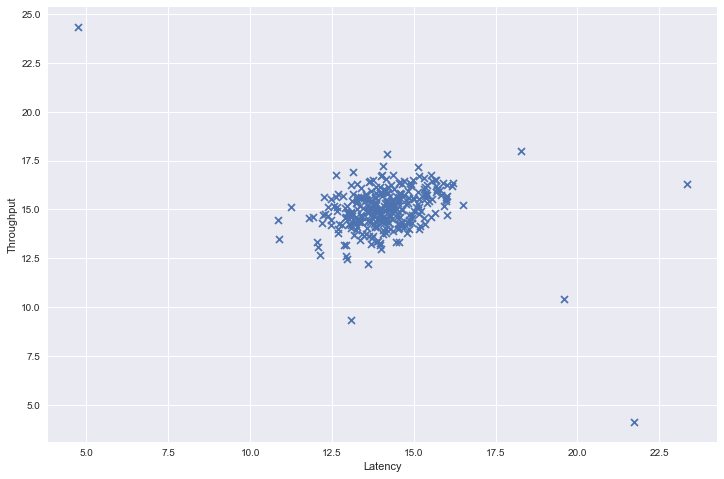

In [68]:
plt.scatter(X[:, 0], X[:, 1], marker='x')
plt.xlabel('Latency')
plt.ylabel('Throughput')

# Gaussian Distribution

$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$
$\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$
$\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [69]:
def estimateGaussian(X):
    
    mean = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    
    return mean, variance

In [70]:
mean, variance = estimateGaussian(X)

In [72]:
def gaussian(X, mean, variance):
    
    p = (1/np.sqrt(2 * np.pi * variance)) * np.exp(np.square(X - mean) / (2 * variance))
    return p

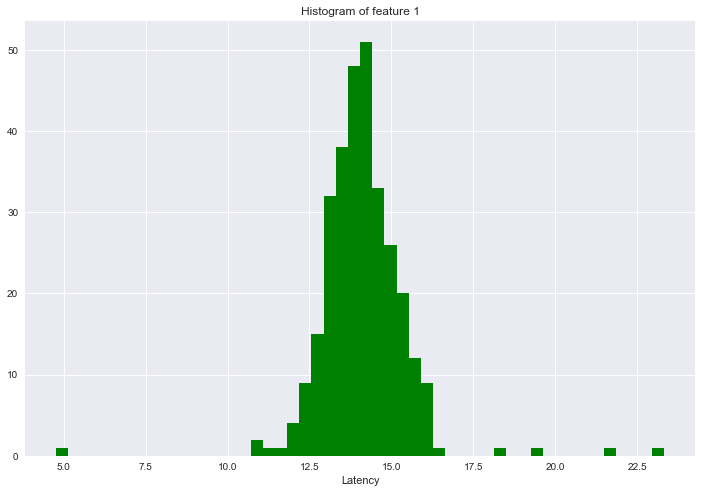

In [73]:
# Ensuring the data comes from a Gaussian distribution
plt.hist(X[:,0], bins=50, color='g')
plt.title('Histogram of feature 1')
plt.xlabel('Latency')
plt.show()

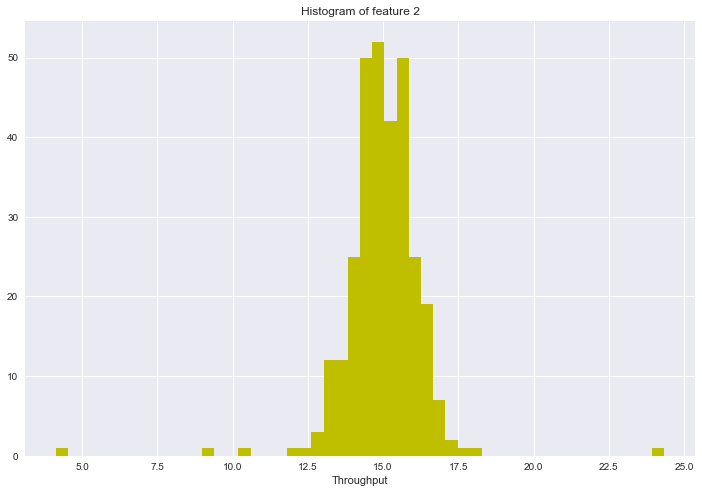

In [74]:
plt.hist(X[:,1], bins=50, color='y')
plt.title('Histogram of feature 2')
plt.xlabel('Throughput')
plt.show()

# Multivariate Gaussian Distribution

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [75]:
def multiVariateGaussian(X, mean, variance):
    
    n = X.shape[1]
    sigma = np.diag(variance)
    X = X - mean
    p = 1/(np.power(2 * np.pi, n/2) * np.sqrt(np.linalg.det(sigma))) * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma)) * X, axis=1))
    return p

In [99]:
p = multiVariateGaussian(X, mean, variance)
p.shape

(307,)

# Visualize the fit

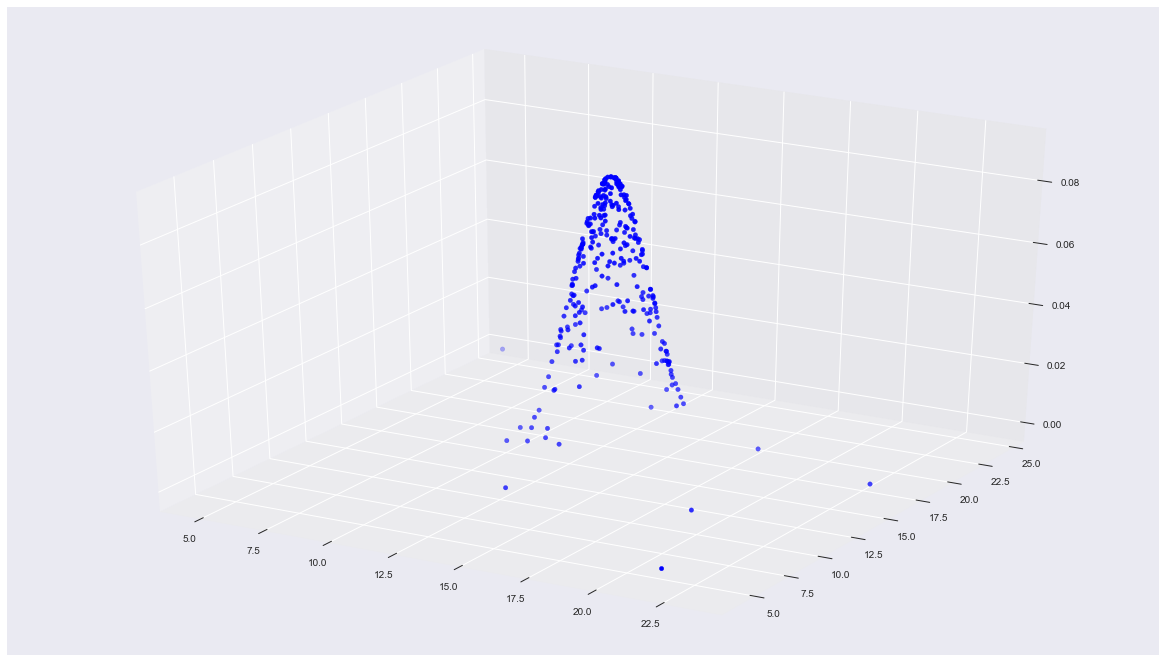

In [100]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], p, c='b')
plt.show()

# Visualise our data on a contour map, to illustrate how we can identify anomalies

In [88]:
def visualise_fit(X, mean, variance):
    plt.figure(figsize=(10, 8))
    i = np.arange(0, 35, 0.5)
    j = np.arange(0, 35, 0.5)
    X1, X2 = np.meshgrid(i, j)
    X1_X2 = np.column_stack((X1.flatten().T, X2.flatten().T))
    Z = multiVariateGaussian(X1_X2, mean, variance)
    Z = Z.reshape(X1.shape)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (Mb/s)")
    plt.xlim((0, 30.0))
    plt.ylim((0, 30.0))
    plt.scatter(X[:, 0], X[:, 1], c='b', marker='x', alpha=0.5)
    plt.contour(X1, X2, Z, 5.0**np.arange(-20, 0, 3))
    plt.show()

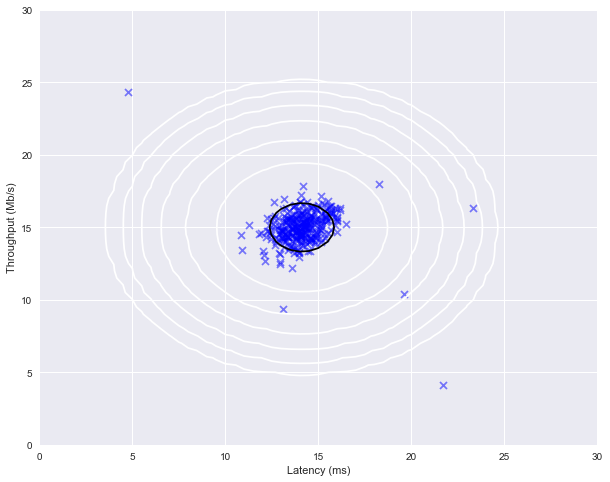

In [101]:
visualise_fit(X, mean, variance)

# Selecting the threshold $\epsilon$

if $ p(x) $ is less than $\epsilon $, then y = 1 (anomaly)

if $ p(x) $ is greater than $\epsilon $, then y = 0 (normal)

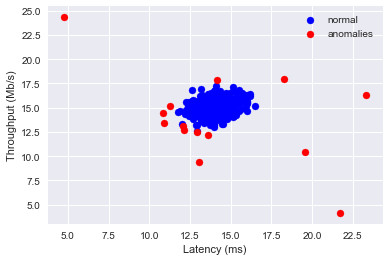

In [102]:
#choosing a random value of epsilon
epsilon = 1e-2

plt.figure(figsize=(6, 4))
plt.scatter(X[p >= epsilon, 0], X[p >= epsilon, 1], c='b', label='normal')
plt.scatter(X[p < epsilon, 0], X[p < epsilon, 1], c='r', label='anomalies')
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (Mb/s)")
plt.legend(loc='best')
plt.show()

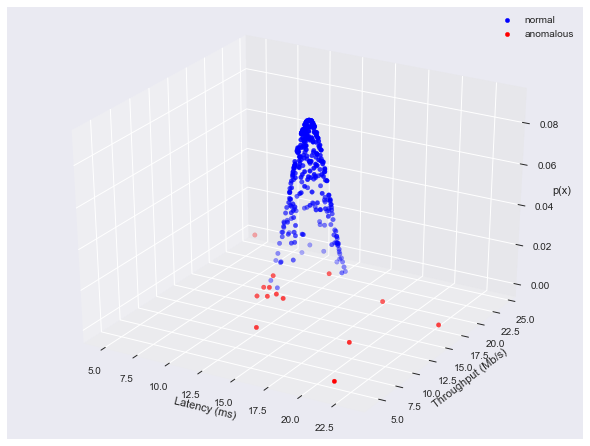

In [103]:
plt.rcParams['figure.figsize'] = (8, 6)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[p >= epsilon, 0], 
           X[p >= epsilon, 1], 
           p[p >= epsilon], 
           c='b', label='normal')
ax.scatter(X[p < epsilon, 0], 
           X[p < epsilon, 1], 
           p[p < epsilon], 
           c='r', label='anomalous')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
ax.set_zlabel('p(x)')
plt.legend(loc='best')
plt.show()

In [107]:
def select_threshold(yval, pvals):
    """Select the best epsilon threshold value to use for outlier selection.
        Uses the ground truth (y_val) and validation set p_vals obtained from the
        multivariate gaussian probability density function. """
    
    # initialise 1000 epsilon values based on p_vals
    epsilons = np.arange(pvals.min(), 
                         pvals.max(), 
                         (pvals.max() - pvals.min()) / 1000)
    
    # create an array to store epsilon and F1 score pairs
    epsilon_F1_pairs = []
    
    for epsilon in epsilons:
        
        # classify anomaly/non-anomaly using epsilon
        y_preds = np.zeros(yval.shape)
        y_preds[pvals < epsilon] = 1
        
        # calc true positives, false positives and false negatives
        true_positives = np.sum(np.logical_and(y_preds == 1, yval == 1))
        false_positives = np.sum(np.logical_and(y_preds == 1, yval == 0))
        false_negatives = np.sum(np.logical_and(y_preds == 0, yval == 1))
        
        # calculate precision and recall - use small value to prevent div by 0
        precision = true_positives / (float(true_positives) + false_positives + 1e-12)
        recall = true_positives / (float(true_positives) + false_negatives + 1e-12)
        
        # calc F1 using precision and recall
        F1_score = (2*precision*recall) / (precision + recall + 1e-12)
        
        # append epsilon, F1 score to epsilon_F1_pairs
        epsilon_F1_pairs.append((epsilon, F1_score, y_preds))
    
    # sort by best F1 score
    epsilon_F1_pairs.sort(key=lambda x: x[1], reverse=True)
    
    return epsilon_F1_pairs[0][0], epsilon_F1_pairs[0][1], epsilon_F1_pairs[0][2]

In [108]:
# calculate p(x) for val data, using mean/variance found from training set, X
pvals = multiVariateGaussian(Xval, mean, variance)

# get top epsilon, F1 score, y predictions
top_epsilon, F1_score, y_val = select_threshold(yval, pvals)

In [109]:
print("The best epsilon value found was: {}.".format(top_epsilon))

The best epsilon value found was: 8.990852779269496e-05.


# Confusion Matrix

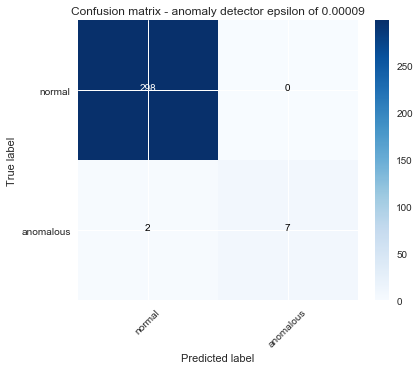

In [111]:
import itertools
from sklearn.metrics import confusion_matrix

# classify anomaly/non-anomaly using epsilon
y_preds = np.zeros(yval.shape)
y_preds[pvals < top_epsilon] = 1

conf_matrix = confusion_matrix(yval, y_preds)
conf_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    
    """ This function plots a simple confusion matrix. """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(6, 5))
plot_confusion_matrix(conf_matrix, classes=['normal', 'anomalous'],
                      title='Confusion matrix - anomaly detector epsilon of {0:.5f}'.format(top_epsilon))
plt.show()

# Visualize the anomalies

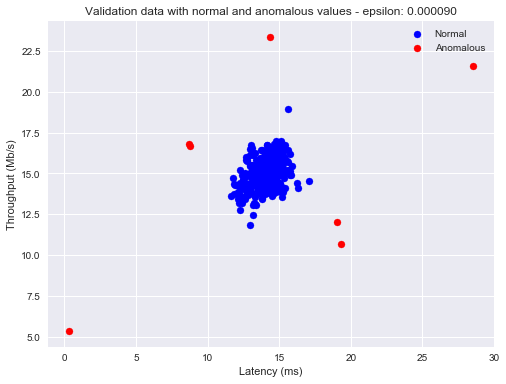

In [112]:
# 2d
plt.figure(figsize=(8, 6))
plt.scatter(Xval[pvals >= top_epsilon, 0], 
            Xval[pvals >= top_epsilon, 1], c='b', label='Normal')
plt.scatter(Xval[pvals < top_epsilon, 0], 
            Xval[pvals < top_epsilon, 1], c='r', label='Anomalous')
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (Mb/s)")
plt.title("Validation data with normal and anomalous values - epsilon: {0:.6f}".format(top_epsilon))
plt.legend(loc='best')
plt.show()

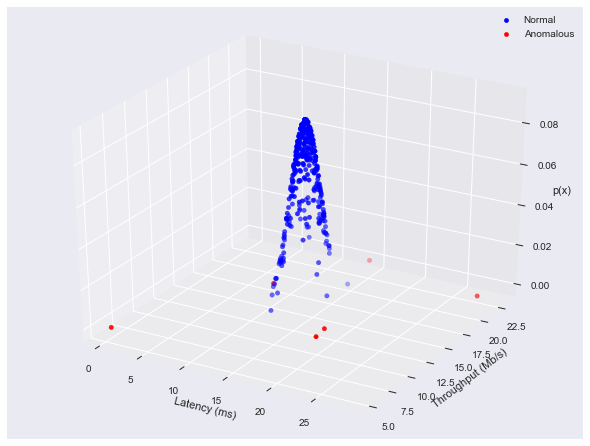

In [114]:
#3d
plt.rcParams['figure.figsize'] = (8, 6)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xval[pvals >= top_epsilon, 0], 
           Xval[pvals >= top_epsilon, 1], 
           pvals[pvals >= top_epsilon], 
           c='b', label='Normal')
ax.scatter(Xval[pvals < top_epsilon, 0], 
           Xval[pvals < top_epsilon, 1], 
           pvals[pvals < top_epsilon], 
           c='r', label='Anomalous')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
ax.set_zlabel('p(x)')
plt.legend(loc='best')
plt.show()

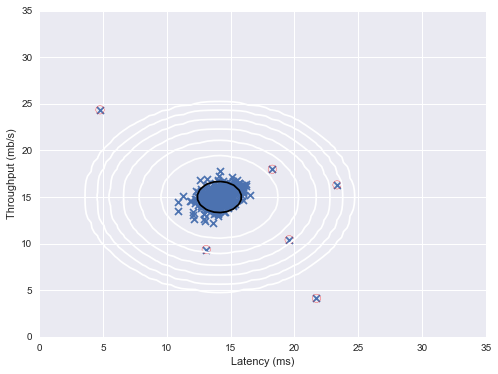

In [115]:
# countour plot

plt.figure(figsize=(8,6))

# plot the data
plt.scatter(X[:,0],X[:,1],marker="x")

# potting of contour
X1,X2 = np.meshgrid(np.linspace(0, 35, num=70), np.linspace(0, 35, num=70))
X1_X2 = np.column_stack((X1.flatten().T, X2.flatten().T))
Z = multiVariateGaussian(X1_X2, mean, variance)
Z = Z.reshape(X1.shape)
plt.contour(X1, X2, Z, 5.0**np.arange(-20, 0, 3))

# Circling of anomalies
outliers = np.nonzero(p < top_epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker ="o",facecolor="none",edgecolor="r",s=70)

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

# High Dimensional Dataset

In [118]:
data2 = loadmat("ex8data2.mat")
X2 = data2["X"]
Xval2 = data2["Xval"]
yval2 = data2["yval"]
print('Shape of X2: ', X2.shape)
print('Shape of Xval2: ', Xval2.shape)
print('Shape of yval2: ', yval2.shape)

Shape of X2:  (1000, 11)
Shape of Xval2:  (100, 11)
Shape of yval2:  (100, 1)


In [117]:
mean, variance = estimateGaussian(X2)

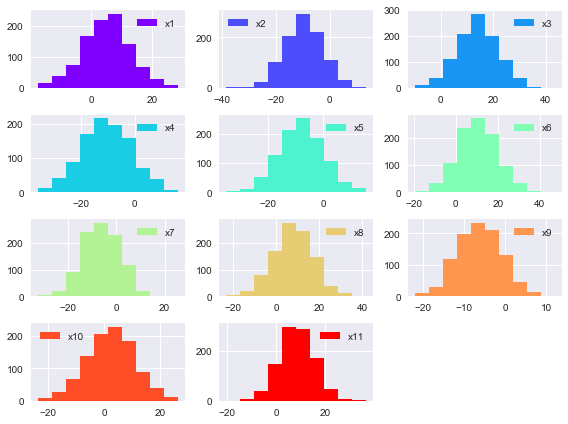

In [121]:
fig, ax = plt.subplots(nrows = 4, ncols = 3)
ax = ax.flatten()

# 11 colours for our plots
color = plt.cm.rainbow(np.linspace(0,1,11))

# plot histogram for each feature column vector
for i in range(11):
    ax[i].hist(X2[:, i], label='x{0}'.format(i+1), color=color[i])
    ax[i].legend(loc='best')
ax[11].remove()
plt.tight_layout()
plt.show()

In [122]:
gaussian_p = multiVariateGaussian(X2, mean, variance)
print(gaussian_p.shape)

(1000,)


In [123]:
pval2 = multiVariateGaussian(Xval2, mean, variance)
print(pval2.shape)

(100,)


In [124]:
top_epsilon2, F1_score2, y_val2 = select_threshold(yval2, pval2)
print("The best epsilon value found was: {}.\n".format(top_epsilon2))
print("The F1 score for this epsilon was: {}.".format(F1_score2))

The best epsilon value found was: 1.377228890761358e-18.

The F1 score for this epsilon was: 0.6153846153840946.


In [125]:
training_outliers = gaussian_p[gaussian_p < top_epsilon2].shape
print("Outliers found in training data, X: {}".format(training_outliers))

Outliers found in training data, X: (117,)


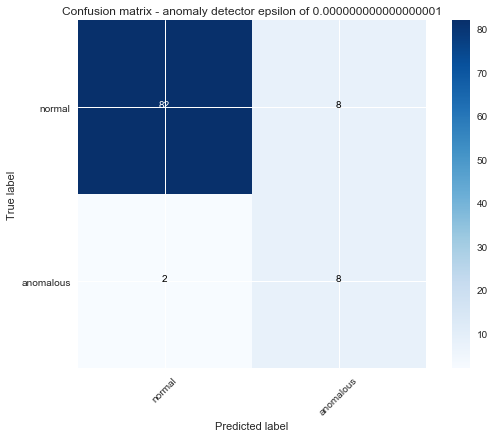

In [130]:
y_preds2 = np.zeros(yval2.shape)
y_preds2[pval2 < top_epsilon2] = 1

conf_matrix2 = confusion_matrix(yval2, y_preds2)

plot_confusion_matrix(conf_matrix2, classes=['normal', 'anomalous'],
                      title='Confusion matrix - anomaly detector epsilon of {0:.18f}'.format(top_epsilon2))
plt.show()